In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import skew, kurtosis
import yfinance as yf


In [3]:
results_comb = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/results_30min_comb_reduced.csv")
counts_comb = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/counts_30min_comb_reduced.csv")
pnl_comb = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/pnl_30min_all_reduced.csv")

results_ib = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/results_30min_ib_reduced.csv")
counts_ib = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/counts_30min_ib_reduced.csv")
pnl_ib = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/pnl_30min_ib_reduced.csv")

results_all = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/results_30min_all_reduced.csv")
counts_all = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/counts_30min_all_reduced.csv")
pnl_all = pd.read_csv("/nfs/home/jingt/dissertation-iceberg/data/trading_strat/pnl_30min_all_reduced.csv")



In [4]:
results_lst = [results_comb, results_ib, results_all]

pnl_lst = [pnl_comb, pnl_ib, pnl_all]

counts_lst = [counts_comb, counts_ib, counts_all]


label_lst = ['HidLit 30min', 'VHI 30min', 'all 30min']

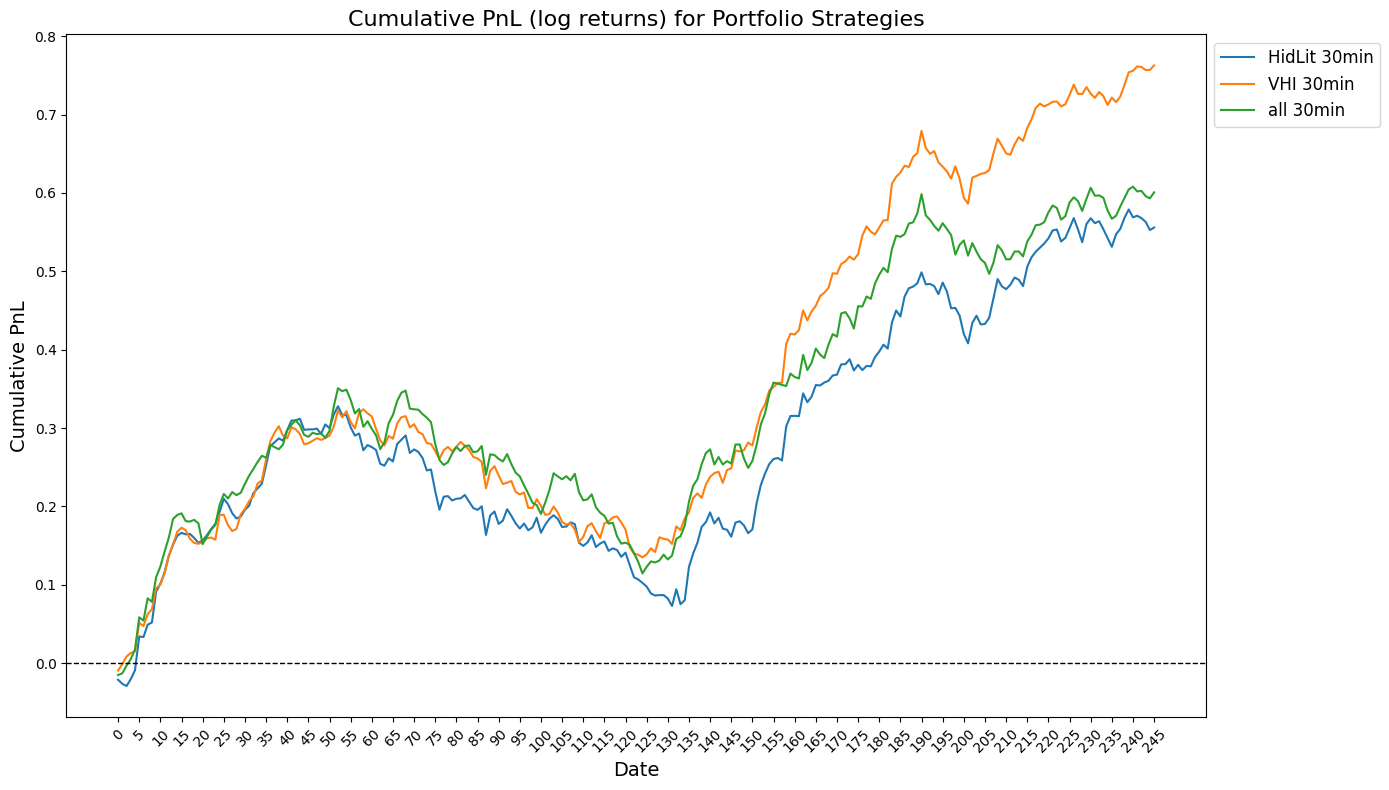

In [5]:
# Plot cumulative PnL for each ticker
plt.figure(figsize=(14, 8))


for results, label in zip(results_lst, label_lst):
    cumulative_pnl = results['PnL'].cumsum().to_frame()
    plt.plot(cumulative_pnl.index, cumulative_pnl['PnL'], label=label)


plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Add title and labels
plt.title('Cumulative PnL (log returns) for Portfolio Strategies', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative PnL', fontsize=14)

# Rotate x-axis labels and reduce ticks
plt.xticks(ticks=range(0, len(cumulative_pnl.index), 5), labels=cumulative_pnl.index[::5], rotation=45)


# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Adjust layout to fit legend
plt.tight_layout()
# Show plot
plt.show()

In [6]:
def sharpe_test(returns, count_df):
    # Calculate the Sharpe ratio
    sharpe_ratio = np.mean(returns) / np.std(returns, ddof=1)
    
    # Number of observations
    T = len(returns)
    
    # Calculate skewness and kurtosis
    g3 = skew(returns)
    g4 = kurtosis(returns, fisher=False)  # fisher=False to match R's kurtosis (which includes the 3)
    
    # Calculate the modified Sharpe ratio statistic
    denominator = np.sqrt((1 - g3 * sharpe_ratio + (g4 - 1) * (sharpe_ratio ** 2) / 4) / (T - 1))
    modified_sharpe_stat = sharpe_ratio / denominator
    # Calculate the two-tailed p-value
    p_value = 2 * min(norm.cdf(modified_sharpe_stat), 1 - norm.cdf(modified_sharpe_stat))
    
    annual_sharpe = sharpe_ratio * np.sqrt(252)
    
    PPT = np.sum(returns) / (count_df[['top_counts', 'bottom_counts']].sum(axis=1).sum()) * 10000
    
    return annual_sharpe, PPT, modified_sharpe_stat, p_value

In [7]:
sharpe_lst = []
SR_test_lst = []
pval_lst = []
ppt_lst = []


for result, counts in zip(results_lst, counts_lst):
    annual_sharpe, PPT, sharpe_stat, p_val = sharpe_test(result['PnL'], counts)
    sharpe_lst.append(annual_sharpe)
    ppt_lst.append(PPT)
    SR_test_lst.append(sharpe_stat)
    pval_lst.append(p_val)

sharpe_df = pd.DataFrame({'Portfolio': label_lst, 'Annual SR': sharpe_lst, 'PPT': ppt_lst,
                          'SR_statistic': SR_test_lst, 'pval': pval_lst})
sharpe_df.sort_values(by='Annual SR', ascending=False, inplace=True)
sharpe_df

,Portfolio,Annual SR,PPT,SR_statistic,pval
1,VHI 30min,4.155359,1.489925,4.267645,0.000020
2,all 30min,2.987253,1.308467,2.944151,0.003238
0,HidLit 30min,2.808981,1.194266,2.827238,0.004695
